In [1]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 999
pd.options.display.max_columns = 9999

In [3]:
data2 = pd.read_csv("esc_est2.csv", na_values = ["NaN", "NaN"], sep = ",")


## Agrupamos por escuela

In [4]:
data2 = data2.groupby(['CNTSCHID']).mean()

## Grabamos esta agrupación para el DASH

In [5]:
data2.to_csv("esc_est2_agru.csv")

In [6]:
##LECTURA DEL FICHERO SPSS Y SUS METADATOS
##Debe estar instalado el paquete de pyreadstat que permite leer ficheros SPSS y SAS
import pyreadstat

df, meta = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\Estudiantes\estudiantesESP1.sav', metadataonly=True)
df2, meta2 = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\Escuelas\Limpieza\escuelasESP1.sav', metadataonly=True)
df3, meta3 = pyreadstat.pyreadstat.read_sav('D:\TFM\Cuestionarios\CuestionariosEsp\profesores\Limpieza\profesoresESP1.sav', metadataonly=True)

## Variables a eliminar de entrada al modelo, como las target, los ID, las regiones, etc...

## Eliminamos las variables del curso al que van, ya que esta demasiado relacionado con el objetivo, y otras que esten demasiado relacionadas
## Como puede ser que hayan repetido

In [7]:

dataMod = data2.drop(['CNTSTUID','LECTURA1','MATES1','CIENCIA1','GLOBAL1','LECTURA2','MATES2','CIENCIA2','GLOBAL2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0_x','Unnamed: 0_y','CCAA'],axis=1)

In [8]:

#dataMod = dataMod.drop(['ST001D01T_7.0','ST001D01T_8.0','ST001D01T_9.0','ST001D01T_10.0','ST001D01T_11.0','EFFORT1_1.0', 'REPEAT_0.0', 'REPEAT_1.0', 'GRADE_0.0', 'GRADE_-2.0', 'EFFORT2_7.0', 'EFFORT1_9.0', 'EFFORT1_2.0'],axis=1)

### <font color="#CA3532">Normalización de los datos</font>

La normalización de datos es muy importante, especialmente cuando se han medido diferentes atributos con diferentes escalas. Aplicamos la normalización solo a los atributos numéricos. Una forma de normalizar bastante común es la estandarización, que consiste en restar la media y escalar para tener una media igual a 0 y una desviación estándar igual a 1.

In [9]:
#dataMod = (dataMod - dataMod.mean()) / dataMod.std() # También se conoce como el "Z-Score"

## Generación del modelo entrenandolo con datos de entrenamiento y probandolo con test

In [10]:
# training /test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
x = std_sc.fit_transform(dataMod.values)
y = data2['GLOBAL1'].values

testsize = 0.2 # in the [0,1] range. 1: 100%
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=testsize, random_state=1)

In [11]:
from sklearn.ensemble import RandomForestRegressor

lr_m =  RandomForestRegressor(random_state=42, max_features='auto', n_estimators= 800, max_depth=8)

lr_m.fit(X_train, y_train)



RandomForestRegressor(max_depth=8, n_estimators=800, random_state=42)

## Prueba del modelo de todos los datos

MAE: 0.013	R^2: 0.870


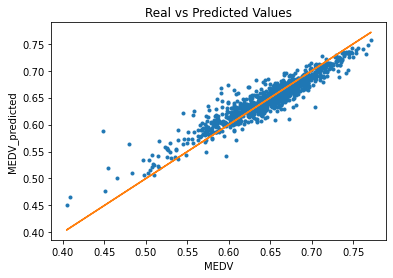

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(x), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

## Resultado con los datos de entrenamiento

MAE: 0.010	R^2: 0.929


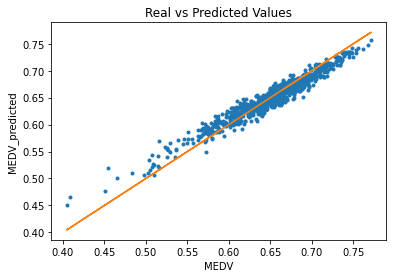

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(X_train), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y_train, y_pred), lr_m.score(X_train, y_train)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y_train, y_pred, '.', y_train, y_train, '-')

## Resultado con los datos de test

MAE: 0.022	R^2: 0.587


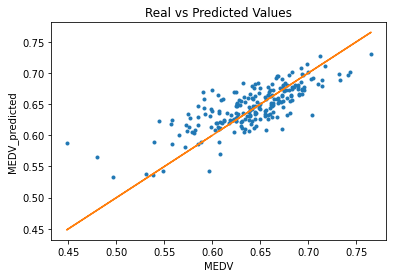

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.clip(lr_m.predict(X_test), 0,  100.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y_test, y_pred), lr_m.score(X_test, y_test)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y_test, y_pred, '.', y_test, y_test, '-')

In [15]:
len(lr_m.feature_importances_)

92

In [16]:
#Dataframe con el coeficiente y nombre columna
VarCoef = pd.DataFrame(lr_m.feature_importances_.T,dataMod.columns.to_list()).sort_values(0)
VarCoef ['Cols']=VarCoef.index

#Dataframe con las descripciones (convertimos un diccionario a un DataFrame)
Des1 = pd.DataFrame([[key, meta.column_names_to_labels[key]] for key in meta.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des2 = pd.DataFrame([[key, meta2.column_names_to_labels[key]] for key in meta2.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des3 = pd.DataFrame([[key, meta3.column_names_to_labels[key]] for key in meta3.column_names_to_labels.keys()], columns=['Cols', 'Desc'])
Des = pd.concat([Des1,Des2, Des3],axis=0)


#Hacemos todos los cruces, para que crucen todas las columnas
VarCoef0 = pd.merge(left=Des,right=VarCoef, left_on='Cols', right_on='Cols')

VarCoef0["Coefi_abs"] = abs(VarCoef0[0])
VarImp = VarCoef0.sort_values("Coefi_abs", ascending=False)
VarImp

,Cols,Desc,0,Coefi_abs
4,ESCS,"Index of economic, social and cultural status",0.212057,0.212057
7,METASPAM,Meta-cognition: assess credibility,0.191115,0.191115
10,HOMEPOS,Home possessions (WLE),0.122493,0.122493
6,METASUM,Meta-cognition: summarising,0.104984,0.104984
26,PISADIFF,Perception of difficulty of the PISA test (WLE),0.056054,0.056054
2,CHANGE,Number of changes in educational biography (Sum),0.019495,0.019495
5,UNDREM,Meta-cognition: understanding and remembering,0.017445,0.017445
13,WEALTH,Family wealth (WLE),0.014762,0.014762
11,CULTPOSS,Cultural possessions at home (WLE),0.013360,0.013360
46,DISCRIM,Discriminating school climate (WLE),0.012003,0.012003


In [21]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{ 'n_estimators': [200, 400, 600, 800]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False]}


{'n_estimators': [200, 400, 600, 800]}

In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

d:\anaconda4\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_